# Automatisation des tâches d'administration système

# M3206 - TP 2 : Analyse de trace de connexion sur un serveur

Ceci est un canevas pour votre compte-rendu de TP, que vous devrez rendre sur [e-campus](http://e-campus.iut-velizy.uvsq.fr/). Vous modifierez directement dans ce document.

## Binôme

* Bénard Philippe
* Blondeau Guillaume

## Préambule

Le fichier de logs est un exemple tiré du fichier `/var/log/messages` généré par `syslogd`, le démon de gestion de log de GNU/Linux.

Les fichiers pour ce TP sont disponible sur le serveur `bach.lisv.uvsq.fr`, vous vous y connecterez avec la commande `scp`. Ouvrez un terminal et tapez la commande :

    scp rtuser@bach.lisv.uvsq.fr:~/test_messages* ./
    
Le mot de passe est `tp1gentoo`. Verifiez le répertoire dans lequel est exécuté ce notebook et copiez-y les fichiers `test_messages100` et `test_messages5000`. Comme le fichier `/var/log/messages` peut être de grande taille (> 10 Mo), nous travaillerons sur des fichiers plus petits de 100 ou 5000 lignes.

Pour ce TP, vous aurez besoin d'installer les bibliothèques suivantes : 
* pyparsing
* pandas
* basemap (facultatif)
Pour installer ces bibliothèques, exécutez la ligne suivante:

    conda install pyparsing pandas basemap
    
Vous aurez également besoin des import suivant:

In [4]:
from __future__ import print_function

Comme vous aller créer des figures, nous allons demander à les afficher dans le corps du notebook :

In [5]:
% matplotlib inline

## Parseur de logs

Pour lire et interpréter (*to parse* en anglais) correctement le fichier de logs, on va utiliser un *parser*. Comme il n'y pas de *parser* déjà disponible pour le fichier `/var/log/messages`, il faut l'écrire. Nous allons utiliser le module `pyparsing` qui permet de définir son propre parser.

Nous allons créer une nouvelle classe de parseur que nous appellerons `SyslogParser`. Nous aurons alors besoin de définir la fonction d'initialisation, appellée quand on crée le parseur et la fonction pour parser un fichier. 

In [6]:
from pyparsing import Word, nums, alphas, string, Combine, Optional, Suppress, Regex, ParseException
 
class SyslogParser(object):
    """Parser for syslog information"""
    def __init__(self):
        """Parser for syslog information
        
        Initialize the parser for a file like /var/log/message, with lines of the form:
        timestamp hostname command[pid]: message
        """
        ints = Word(nums)
        # extract timestamp
        month = Word(string.ascii_uppercase, string.ascii_lowercase, exact=3)
        day = ints
        hour = Combine(ints + ":" + ints + ":" + ints)
        timestamp = month + day + hour
        # hostname
        hostname = Word(alphas + nums + "_" + "-" + ".")
        # appname
        command = Word(alphas + "/" + "-" + "_" + ".") + Optional(Suppress("[") + ints + Suppress("]")) + Suppress(":")
        # message
        message = Regex(".*")
        # pattern build
        self.__pattern = timestamp + hostname + command + message

    def parse(self, line):
        """Parser for syslog information
        
        Parse file like /var/log/message, with lines of the form:
        timestamp hostname command[pid]: message
        """
        payload = {}
        try:
            parsed = self.__pattern.parseString(line)
            payload["timestamp"] = parsed[0]+" "+parsed[1]+" "+parsed[2]
            payload["hostname"] = parsed[3]
            payload["command"] = parsed[4]
            payload["pid"] = parsed[5]
            payload["message"] = parsed[6]
        except ParseException:
            print ("error parsing line:", line)
            pass
        except:
            raise
        return payload
    
    def parseSSH(self, line):
        """Parser syslog for sshd information
        
        Parse files like /var/log/message, with lines of the form:
        timestamp hostname command[pid]: message
        Only the information relevant to sshd are kept.
        """
        payload = {}
        try:
            parsed = self.__pattern.parseString(line)
            if parsed[4] != 'sshd':
                return
            payload["timestamp"] = parsed[0]+" "+parsed[1]+" "+parsed[2]
            payload["pid"] = parsed[5]
            message = parsed[6].split(';')
            msg = []
            for f in message:
                msg.append(f.split(':'))
            if len(msg) == 1 or len(msg) == 2:
                if message[0].split()[0] == 'reverse':
                    payload['reversedMapping'] = False
                    return payload
                else:
                    return 
            if msg[1][1] == ' Version':
                payload["client"] = msg[4][1]
            if msg[1][1] == ' Authname':
                payload["user"] = msg[3][1].split('[')[0]
            payload['ip'] = msg[2][1]
        except ParseException:
            print ("error parsing line:", line)
            pass
        except:
            print ("error parsing line:", line)
            raise
        return payload

Après avoir importé les modules et fonctions dont nous avions besoin, nous avons crée la classe `SyslogParser` et nous lui avons associé deux fonctions `__init__(self)` (qui est obligatoire) et `parse(self, line)` qui nous permet de parser la ligne `line` passée en argument. 

La fonction `__init__(self)` utilise les outils fournis par le module `pyparsing` pour définir un patron (ou *pattern* en anglais) de ligne qui est appelé `__pattern`. Celui ci est de la forme : `timestamp hostname command[pid]: message` et utilise les fonctions de pyparsing pour une robustesse maximale. On définit ensuite la fonction `parse(self, line)` qui sert à parser une ligne. La ligne est donnée au parseur de patron `__pattern` qui retourne une liste appelée `parsed`. Cette liste est utilisée pour créer un dictionnaire nommé `payload` (qu'on peut traduire par *message utile* en français). Ce dictionnaire à 5 champs (ou `keys`):

* `timestamp` : la date
* `hostname` : le nom de la machine
* `command` : le nom de l'application qui écrit dans le fichier de logs
* `pid` : le PID de l'application (son numéro de processus)
* `message` : le message que l'application à envoyé

La fonction `parseSSH(self, line)` permet de traiter uniquement les lignes générées par le démon `sshd` et de les analyser plus finement. Cette fonction parse la ligne `line` donnée en paramètre et retourne le dictionnaire `payload` qui contient suivant (ceux qui sont facultatifs sont indiqués) :

* `timestamp` : la date
* `pid` : le PID de l'application
* `client` : le nom et la version du client ssh (facultatif)
* `user` : le nom de l'utilisateur utilisé (facultatif)
* `reversedMapping` : vérification du *reverse mapping* (pour éviter les tentatives d'IP spoofing)

Nous allons vérifier si notre parseur fonctionne avec un exemple simple, une ligne tirée du fichier `messages`.

In [8]:
sample_line = "Nov 28 03:50:01 bach cron[16620]: (root) CMD (test -x /usr/sbin/run-crons && /usr/sbin/run-crons)"
parser = SyslogParser()
fields = parser.parse(sample_line)

##### Question

Affichez la ligne à traiter et la ligne traitée pour vérifier si le code à bien fonctionné

In [10]:
print (fields)

{'timestamp': 'Nov 28 03:50:01', 'pid': '16620', 'hostname': 'bach', 'command': 'cron', 'message': '(root) CMD (test -x /usr/sbin/run-crons && /usr/sbin/run-crons)'}


## Analyse des logs

Après avoir vérifié que notre parseur a bien fonctionné, et que tous les champs sont bien renseignés. La ligne parsée génère un dictionnaire, appellé `fields` ici, dont les entrées sont les différents champs.

Avant de traiter le vrai fichier `/var/log/messages`, nous allons utiliser un fichier de test, qui contient les premières lignes de `/var/log/messages`. Cela nous permettra de faire une première analyse, de vérifier le bon fonctionnement sans avoir besoin de traiter l'intégralité des données du vrai fichier. Une fois les tests réalisés, nous pourrons traiter l'intégralité du fichier `message`.

##### Question

Écrivez le code qui permet d'ouvrir le fichier `test_messages5000` et qui parse chacune de ses lignes. Les lignes ainsi parsées  sont à aggréger dans une liste que vous appelerez `log_list`.

In [19]:
with open ("test_messages5000") as f:
    lignes = f.readlines()
    parser = SyslogParser()
    log_list = []
    for l in lignes:
        fields = parser.parse(l)
        log_list.append(fields)

Vérifiez la taille de `log_list`, qui doit être égale à 5000 si vous avez ouvert `test_messages5000`.

In [20]:
len(log_list[0:])

5000

Il y a bien un nombre de lignes relativement faible pour le fichier de test, comparativement aux 200 000 lignes du "vrai" fichier `/var/log/messages`.

Nous allons maintenant utiliser le module `pandas` pour mettre en forme les données. Ce module permet de créer des *DataFrames* : ce sont des conteneurs qui permettent de mettre l'information en forme.

In [69]:
import pandas as pd
from pandas import Series, DataFrame, Panel
df = DataFrame(log_list)

##### Question

Affichez les 3 premières éléments de `df`. Les *DataFrame* peuvent se manipuler comme des listes.

In [70]:
dd = df[0:3]
ts = []
for i in dd.timestamp:
    ts.append(i.split()[2])
dd.index = pd.to_datetime(ts)
dd.info()
dd.command.resample('1t', how='count')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3 entries, 2016-11-24 03:10:03 to 2016-11-24 03:10:03
Data columns (total 5 columns):
command      3 non-null object
hostname     3 non-null object
message      3 non-null object
pid          3 non-null object
timestamp    3 non-null object
dtypes: object(5)
memory usage: 144.0+ bytes


2016-11-24 03:10:00    3
Freq: T, Name: command, dtype: int64

Nous allons maintenant utiliser le champ `timestamp` comme étiquettes temporelles pour nos logs :

In [71]:
# Pour parer à une erreur de traitement de to_datetime
ts = []
for i in df.timestamp:
    ts.append(i.split()[2])
df.index = pd.to_datetime(ts)
del df['timestamp']


Il est possible d'afficher les informations sur cette *DataFrame* avec:

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5000 entries, 2016-11-24 03:10:03 to 2016-11-24 01:12:04
Data columns (total 4 columns):
command     5000 non-null object
hostname    5000 non-null object
message     5000 non-null object
pid         5000 non-null object
dtypes: object(4)
memory usage: 195.3+ KB


Il est également possible d'afficher les informations sur le contenus et les différents champs de la *DataFrame* :

In [73]:
df.describe()

,command,hostname,message,pid
count,5000,5000,5000,5000
unique,4,1,1607,1022
top,sshd,bach,pam_unix(sshd:auth): authentication failure; l...,22593
freq,4842,5000,463,21


Regardons maintenant quels sont les applications qui ont envoyées des messages, nous allons utiliser la fonction `unique` pour afficher l'ensemble des valeurs prises par le champs `command`.

In [74]:
df.command.value_counts()

sshd         4842
cron          154
syslog-ng       2
run-crons       2
Name: command, dtype: int64

##### Question

Quelle est la commande la plus fréquente ? Que pouvez vous dire sur les tâches de `cron` ?

C'est sshd (executer 4842 fois) , cron permet de planifier des taches (executer 154 fois)

## Figures et visualisations

On peut générer un histogramme à partir de ces données de la façon suivante. On regroupe les informations de la *DataFrame* par commande. On calcule ensuite le nombre de chaque commande avec la fonction `size()` puis on affiche un diagramme en bâtons (*bars* en anglais). La bibliothèque Pandas permet de générer facilement toute sort de graphique en appelant la fonction `plot()` avec comme argument `kind`. Les types possibles sont: 

* `bar` ou `barh` pour les diagrammes (verticaux ou horizontaux)
* `hist` pour les histogrammes
* `box` pour les boîtes à moustaches
* `kde` ou `density` pour les figures de densité de probabilités
* `area` pour les aires 
* `scatter` pour les nuages de points
* `hexbin` pour les cartes hexagonales
* `pie` pour les camemberts

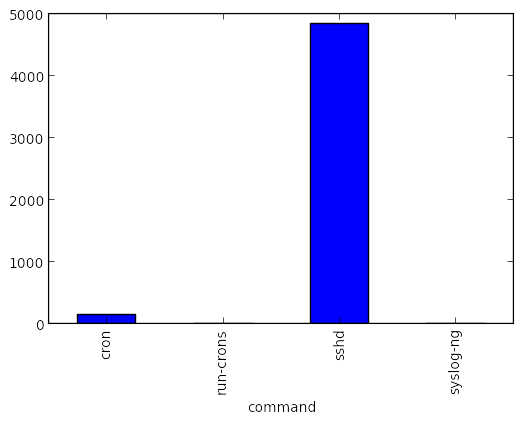

In [75]:
grouped_status = df.groupby('command')
grouped_status.size().plot(kind='bar')

Regardons maintenant le nombres de messages générés toutes les dix minutes. On va donc ré-échantilloner les commandes avec `resample()` en faisant des paquets de 10 minutes (indiqué ici par `10t`) dans lesquels on va sommer chaque commande (avec `how='count'`). 

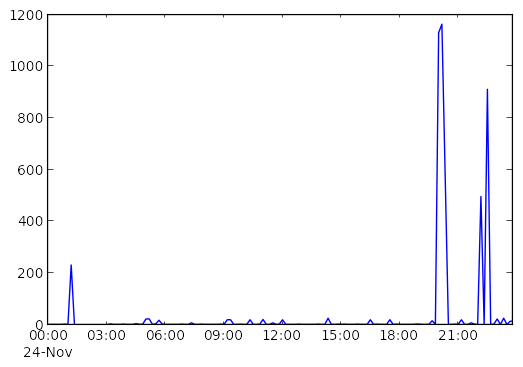

In [78]:
df_s = df.command.resample('10t', how='count')
df_s.plot()

Pour voir la part respectives de chaque applications dans la génération de log, on peut séparer les données quantitative pour chaque application puis les regrouper dans un *DataFrame* commun. On peut en profiter pour regrouper les activités de `cron` de `run-crons` sous la même étiquette. Pour avoir des résultats interprétables, on aggrège les messages par groupe de 2h (`120t`).

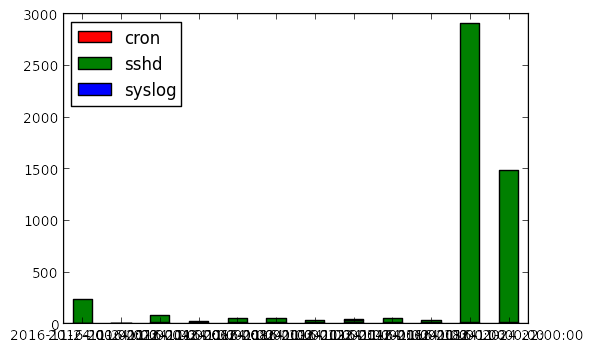

In [79]:
t_span = '120t'
df_cron = df['command'][df['command'].isin(['cron', 'run-crons']) ].resample(t_span, how='count')
df_sshd = df['command'][df['command'] == 'sshd'].resample(t_span, how='count')
df_syslog = df['command'][df['command'] == 'syslog-ng'].resample(t_span, how='count')

status_df = DataFrame({'cron': df_cron, 
                       'sshd': df_sshd, 
                       'syslog': df_syslog})
status_df.plot(kind="bar", stacked=True, color=("r", "g","b"), xticks=())
#legend()

## Analyse des traces SSH

Voici un exemple de traces SSH : 

In [90]:
samples=[
"Nov 28 05:01:44 bach sshd[17038]: SSH: Server;Ltype: Version;Remote: 122.225.97.104-29185;Protocol: 2.0;Client: libssh2_1.4.2", 
"Nov 28 05:01:45 bach sshd[17038]: SSH: Server;Ltype: Kex;Remote: 122.225.97.104-29185;Enc: aes128-ctr;MAC: hmac-sha1;Comp: none [preauth]",
"Nov 28 05:01:59 bach sshd[17038]: SSH: Server;Ltype: Authname;Remote: 122.225.97.104-29185;Name: root [preauth]",
"Nov 28 05:01:59 bach sshd[17038]: reverse mapping checking getaddrinfo for mx7.fund123.cn [122.225.97.104] failed - POSSIBLE BREAK-IN ATTEMPT!",
"Nov 28 05:01:59 bach sshd[17038]: User root from 122.225.97.104 not allowed because not listed in AllowUsers",
"Nov 28 05:01:59 bach sshd[17038]: input_userauth_request: invalid user root [preauth]",
"Nov 28 05:01:59 bach sshd[17038]: Connection closed by 122.225.97.104 [preauth]"]

On peut voir que les informations sur la connexion SSH sont réparties sur plusieurs messages :

* Le premier indique l'adresse IP, la version du protocole, le client. 
* Le second précise l'encryptage et les moyens cryptographiques. 
* Le troisième donne l'utilisateur utilisé pour la connexion.
* Le quatrième indique que le nom de la machine ne correspond pas à l'adresse IP.
* Le cinquième explique que `root` n'est pas admis à se connecter en SSH.
* Le sixième indique le message envoyé au client.
* Le septième précise que la connexion a été fermée par le client.

Ces sept message sont issus du même processus, on peut voir que le PID est le même pour tous. Or le parseur SSH permet seulement d'analyser les logs lignes à lignes. Le résultat est le suivant :

In [91]:
parser = SyslogParser()
parser = SyslogParser()
for s in samples:
    print ("Ligne parsée :\n", parser.parseSSH(s))

Ligne parsée :
 {'timestamp': 'Nov 28 05:01:44', 'client': ' libssh2_1.4.2', 'pid': '17038', 'ip': ' 122.225.97.104-29185'}
Ligne parsée :
 {'timestamp': 'Nov 28 05:01:45', 'pid': '17038', 'ip': ' 122.225.97.104-29185'}
Ligne parsée :
 {'timestamp': 'Nov 28 05:01:59', 'pid': '17038', 'user': ' root ', 'ip': ' 122.225.97.104-29185'}
Ligne parsée :
 {'timestamp': 'Nov 28 05:01:59', 'pid': '17038', 'reversedMapping': False}
Ligne parsée :
 None
Ligne parsée :
 None
Ligne parsée :
 None


Le parseur retourne des informations différentes pour les 4 premières lignes et ne retourne rien pour les 3 dernières.

##### Question

Écrivez le code nécessaire pour 

* Créer une liste appelée `sshlog_list` qui va stocker toutes les lignes parsées
* Supprimer les élements vide de la liste (leur valeur est `None`)
* Traiter les éléments de la liste pour fusionner ceux qui ont le même PID. Vous utiliserez `a.update(b)` qui permet de mettre à jour les champs de `a` avec ceux de `b` et `del b` qui permet du supprimer `b`. 

In [92]:

parser = SyslogParser()
for s in samples:
    sshlog_list = parser.parseSSH(s)
    print (sshlog_list)

{'timestamp': 'Nov 28 05:01:44', 'client': ' libssh2_1.4.2', 'pid': '17038', 'ip': ' 122.225.97.104-29185'}
{'timestamp': 'Nov 28 05:01:45', 'pid': '17038', 'ip': ' 122.225.97.104-29185'}
{'timestamp': 'Nov 28 05:01:59', 'pid': '17038', 'user': ' root ', 'ip': ' 122.225.97.104-29185'}
{'timestamp': 'Nov 28 05:01:59', 'pid': '17038', 'reversedMapping': False}
None
None
None


##### Question

Après avoir validé votre code sur la question précédente, adaptez le pour traiter le fichier `test_messages100`.

In [96]:
with open ("test_messages100") as f:
   

{'timestamp': 'Nov 28 07:21:40', 'pid': '17858', 'hostname': 'bach', 'command': 'sshd', 'message': 'input_userauth_request: invalid user dev [preauth]'}


Convertissons maintenant la liste obtenue sur ce fichier en *DataFrame* :

In [93]:
df = DataFrame(sshlog_list)
ts = []
for i in df.timestamp:
    ts.append(i.split()[2])
df.index = pd.to_datetime(ts)
del df['timestamp']

AttributeError: 'DataFrame' object has no attribute 'timestamp'

Vous pouvez utiliser `df.info()` et `df.describe()` pour vérifier les informations sur la *DataFrame*.

##### Question

Utilisez la fonction `plot()` pour mettre sous forme de figures les informations de votre fichier de message. Vous proposerez une petite analyse des informations ainsi obtenues.

##### Question (*)

Cette question est facultative. Vous utiliserez le module Basemap pour afficher une carte sur monde sur laquelle vous afficherez les positions géographiques associées à ces adresses IP. Pour cela, vous utiliserez le code suivant qui permet de récuperer les coordonnées de latitude et de longitude pour chaque IP. Le site freegeoip.net qui propose ce service limite le nombre de demandes. Vous devrez donc d'abord enlever les doublons, c'est à dire éviter de faire plusieurs requêtes pour la même IP. 

In [ ]:
import re
from csv import reader
from urllib.request import urlopen # drop request for python 2 version
FREE_GEOIP_CSV_URL = "http://freegeoip.net/csv/%s"
def valid_ip(ip):

    pattern = r"\b(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\b"

    return re.match(pattern, ip)

def __get_geodata_csv(ip):
    if not valid_ip(ip):
        raise Exception('Invalid IP format', 'You must enter a valid ip format: X.X.X.X')

    URL = FREE_GEOIP_CSV_URL % ip
    response_csv = reader(urlopen(URL))
    csv_data = response_csv.next()

    return {
        "status": u"True" == csv_data[0],
        "ip":csv_data[1],
        "countrycode":csv_data[2],
        "countryname":csv_data[3],
        "regioncode":csv_data[4],
        "regionname":csv_data[5],
        "city":csv_data[6],
        "zipcode":csv_data[7],
        "latitude":csv_data[8],
        "longitude":csv_data[9]
    }

def get_geodata(ip):
    return __get_geodata_csv(ip)

In [ ]:
# écrivez le code qui permette de récupérer lats, la liste des latitudes,
# et lons, la listes des longitudes associés aux IP uniques

In [ ]:
from mpl_toolkits.basemap import Basemap

m = Basemap(projection='mill') # creation de la carte en utilisant la projection de Millner
figure(figsize(10,14)) # on change la taille de la figure
x, y = m(lons, lats) # lons et lats sont les listes des latitudes et des longitudes des IP
m.scatter(x, y, marker='o', color='r') # on affiche des points au coordonnées des IP
m.drawcoastlines(color='SaddleBrown') # on affiche les côtes
m.drawmapboundary(fill_color='SkyBlue') # on remplit les océans
_ = m.fillcontinents(color='BurlyWood',lake_color='SkyBlue', zorder=0) # on remplit les continents